# **Imports** 

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# keras imports for the dataset and building our neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, MaxPooling2D, Rescaling

# import pyplot module
import matplotlib.pyplot as plt

# importing OpenCV(cv2) module
import cv2
from google.colab.patches import cv2_imshow # in order to show images because collab does not use cv2.imshow

# importing sklearn modules
# to calculate accuracy
from sklearn.metrics import accuracy_score
# from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics 
from sklearn.utils import shuffle

# basic imports
import os

# importing numpy 
import numpy as np

# import shutil 
import shutil

# impoer drive for google drie mount 
from google.colab import drive

import pathlib
import PIL.Image
import seaborn as sns
# import kaggle

# **Dataset**

American Sign Language Dataset source (train 
dataset): https://www.kaggle.com/datasets/kapillondhe/american-sign-language

In [ ]:
#data 
# kaggle datasets download -d kapillondhe/american-sign-language 4.6GB
# ! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kapillondhe/american-sign-language

100% 4.63G/4.64G [00:44<00:00, 168MB/s]
100% 4.64G/4.64G [00:44<00:00, 112MB/s]


# **Unzip the dataset Images**

### **Zip structure:**


```
ROOT/
  -->className1/
      -->c1_image1.jpeg
      -->c1_image2.jpeg
  -->className2/
      -->c2_image1.jpeg
      -->c2_image2.jpeg
  -->className3/
      -->c3_image1.jpeg
      -->c3_image2.jpeg
```



In [ ]:
shutil.unpack_archive("./american-sign-language.zip", "./")

# **Create Dataset**

Create a dataset based on the available images and splits 80% for training and 20% for validation

In [ ]:
batch_size = 15
img_height = 32
img_width = 32
path = os.path.join("/content","ASL_Dataset/Train/")
print(path)
train_ds = image_dataset_from_directory(
  path,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

validation_ds = image_dataset_from_directory(
  path,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
# classes
class_names = train_ds.class_names
print(class_names)


/content/ASL_Dataset/Train/
Found 165670 files belonging to 28 classes.
Using 115969 files for training.
Found 165670 files belonging to 28 classes.
Using 49701 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Nothing', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
# classes num
print(len(class_names))
# train_ds

28


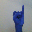

In [ ]:
# display image 
anImage = None 
for images, labels in train_ds.take(1):
  anImage = images[0]
  cv2_imshow(images[0].numpy().astype("uint8"))
  break

# **Configure the dataset for performance**

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:


*   Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache
*   Dataset.prefetch overlaps data preprocessing and model execution while training.




In [ ]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


# **Standardize the data**

Images normalization im range [0 , 1]

In [ ]:
# Standardize the data [0, 1]
normalization_layer = Rescaling(1./255)

# aplly the layer to the dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

#check if the values are in the coorect range [0,1]
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0754902 0.71470594


# **Build the Convolutional Neural Network**



1.   Create model and the model layers
2.   Compile the model
3.   Display the model architecture



In [ ]:
# build the multilayes CNN

model = Sequential([
  Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(class_names)
)
])


In [ ]:
# compile the model 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
#display model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          1

# **Run the Convolutional Neural Network**

In [ ]:
# train and test model
cnn_epochs = 10

history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=cnn_epochs
)


Epoch 1/10
7732/7732 [==============================] - 94s 10ms/step - loss: 0.1538 - accuracy: 0.9519 - val_loss: 0.0172 - val_accuracy: 0.9945
Epoch 2/10
7732/7732 [==============================] - 28s 4ms/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 0.0129 - val_accuracy: 0.9965
Epoch 3/10
7732/7732 [==============================] - 28s 4ms/step - loss: 0.0107 - accuracy: 0.9969 - val_loss: 0.0037 - val_accuracy: 0.9988
Epoch 4/10
7732/7732 [==============================] - 28s 4ms/step - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.0076 - val_accuracy: 0.9975
Epoch 5/10
7732/7732 [==============================] - 28s 4ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0060 - val_accuracy: 0.9978
Epoch 6/10
7732/7732 [==============================] - 28s 4ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.0068 - val_accuracy: 0.9986
Epoch 7/10
7732/7732 [==============================] - 28s 4ms/step - loss: 0.0059 - accuracy: 0.9984 - val_loss: 0.0034 - val_a

# **Visualization of the training Results**

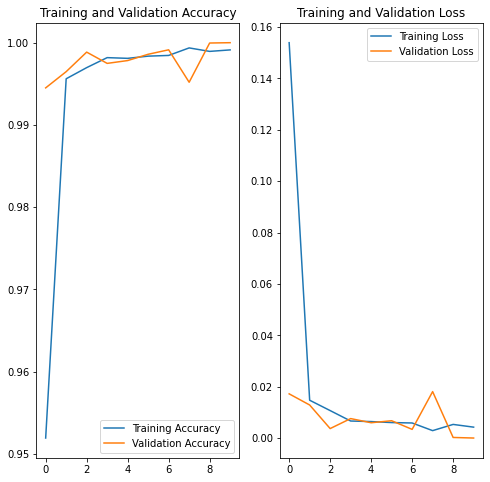

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(cnn_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


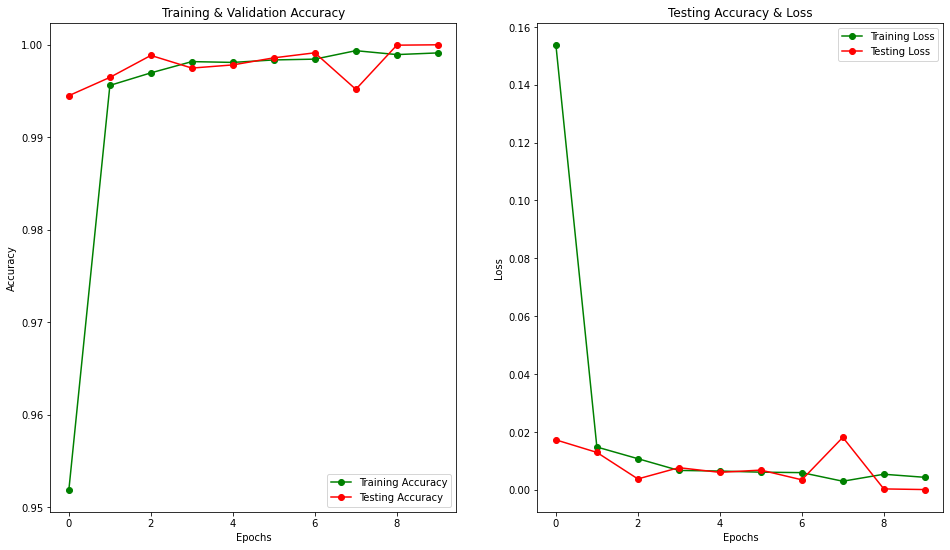

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Save model

In [ ]:
model.save('largeDataset_cnn_model.h5') 

In [ ]:
model.save('largeDataset_cnn_model') 

INFO:tensorflow:Assets written to: largeDataset_cnn_model/assets


# **Predict**

This image most likely belongs to Z with a 100.00 percent confidence.


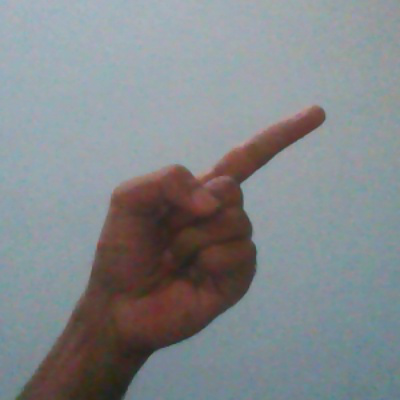

In [ ]:
# from local directory
data_dir = pathlib.Path("/content/ASL_Dataset/Test/")

images = list(data_dir.glob("Z/*"))

img = tf.keras.utils.load_img(
    str(images[0]), target_size=(img_height, img_width)
)

# from web 
# img_url = "https://transfer.sh/get/Gg3i5w/l.jpg"
# img_path = tf.keras.utils.get_file('j', origin=img_url)

# img = tf.keras.utils.load_img(
#     img_path, target_size=(32, 32)
# )

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

#local version
PIL.Image.open(str(images[0]))
# web version
# PIL.Image.open(img_path)


In [ ]:
path = os.path.join("/content","ASL_Dataset/Test/")
prediction_ds = image_dataset_from_directory(
  path,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

predictions = model.predict(
    prediction_ds
)


print(predictions)

Found 112 files belonging to 28 classes.
Using 33 files for validation.
[[-1.53720474e+02 -1.55105820e+02 -6.71325836e+01 -3.89891129e+01
  -1.52622696e+02 -1.42477732e+01 -7.36854248e+01 -7.43614655e+01
  -3.26882973e+01 -5.92213287e+01 -4.28417168e+01 -1.14058485e+01
  -1.21089989e+02 -8.70718002e+01 -1.42644821e+02 -6.60195465e+01
  -7.59241867e+01 -6.49310379e+01 -8.88115616e+01 -1.27236076e+02
   7.42281799e+01 -9.46624756e+01 -7.67854462e+01 -2.58560066e+01
  -4.56302567e+01 -6.59657364e+01 -6.63138504e+01 -4.68140945e+01]
 [-6.95578079e+01 -9.09285278e+01 -5.70654755e+01 -6.24741287e+01
  -4.38218269e+01 -1.26750889e+01 -1.49430981e+01 -6.24529495e+01
  -9.91689491e+00 -4.21548538e+01 -3.73338814e+01 -6.55833130e+01
  -5.29151306e+01 -4.67536774e+01 -1.97050381e+01 -2.46269894e+01
  -2.58908367e+01 -2.83231850e+01 -5.60272522e+01 -2.39335690e+01
  -2.06230354e+01 -3.61508904e+01 -6.73266449e+01 -1.03083754e+01
   3.19579735e+01 -4.86406441e+01  3.65195036e-01 -2.66376724e+01]
 [